# CNN을 통한 단일 이미지 학습

## Google Colab 링크

https://colab.research.google.com/drive/1LO9LJAGce41EhLOy-BcpjHAZvry6b6JG#scrollTo=U8-TLsKCvwF8

**학습 데이터세트는 AI Hub에서 신청하여 받았고, 저작자는 한국지능정보사회진흥원이다.**


## 참고자료

https://lsjsj92.tistory.com/387

In [ ]:
# Google Colab 재시작
!kill -9 -1

## 구글 드라이브 마운드

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터 분류

먼저 이미지를 배열화시킨다.

다음 이미지를 훈련 데이터, 테스트 데이터로 나눈다.

이후 numpy 형태로 저장한다.

In [2]:
from PIL import Image
import os, glob, sys, numpy as np
from sklearn.model_selection import train_test_split
from keras.utils import np_utils

## 데이터세트 다운로드

In [3]:
!gdown --id 1AeNCnN8nOQI2q3p7kpeht2y6Aa95eHmT --output other_food.zip

Downloading...
From: https://drive.google.com/uc?id=1AeNCnN8nOQI2q3p7kpeht2y6Aa95eHmT
To: /content/other_food.zip
348MB [00:08, 40.0MB/s]


In [ ]:
!unzip other_food.zip

In [5]:
ls

drive/  other_food/  other_food.zip  sample_data/


In [6]:
import pathlib
img_dir = 'other_food'
data_dir = pathlib.Path(img_dir)

In [7]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

2903


In [8]:
categories = ['beans', 'pizzas', 'fried_chickens']
np_classes = len(categories)

image_w = 64
image_h = 64


pixel = image_h * image_w * 3

X = []
y = []

for idx, beans in enumerate(categories):
    img_dir_detail = img_dir + "/" + beans
    files = glob.glob(img_dir_detail+"/*.jpg")


    for i, f in enumerate(files):
        try:
            img = Image.open(f)
            img = img.convert("RGB")
            img = img.resize((image_w, image_h))
            data = np.asarray(img)
            #Y는 0 아니면 1이니까 idx값으로 넣는다.
            X.append(data)
            y.append(idx)
            if i % 300 == 0:
                print(beans, " : ", f)
        except:
            print(beans, str(i)+" 번째에서 에러 ")

beans  :  other_food/beans/Img_025_0457.jpg
beans  :  other_food/beans/Img_025_0824.jpg
beans  :  other_food/beans/Img_025_0550.jpg
beans  :  other_food/beans/Img_025_0091.jpg
pizzas  :  other_food/pizzas/Img_027_0341.jpg
pizzas  :  other_food/pizzas/Img_027_0519.jpg


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:788: UserWarning: Corrupt EXIF data.  Expecting to read 12 bytes but only got 4. 
  warnings.warn(str(msg))
/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


pizzas  :  other_food/pizzas/Img_027_0570.jpg
pizzas  :  other_food/pizzas/Img_027_0597.jpg
fried_chickens  :  other_food/fried_chickens/Img_028_0861.jpg
fried_chickens  :  other_food/fried_chickens/Img_028_0882.jpg
fried_chickens  :  other_food/fried_chickens/Img_028_0879.jpg
fried_chickens  :  other_food/fried_chickens/Img_028_0577.jpg


In [10]:
!mkdir numpy_data

In [11]:
X = np.array(X)
Y = np.array(y)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)

xy = (X_train, X_test, Y_train, Y_test)
np.save("numpy_data/binary_image_data.npy", xy)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


## 모델 훈련

이제 훈련을 시작한다.

In [19]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
# import tensorflow.python.keras.backend as K
import tensorflow.keras.backend as K

In [13]:
X_train, X_test, y_train, y_test = np.load("numpy_data/binary_image_data.npy", allow_pickle=True)
print(X_train.shape)
print(X_train.shape[0])
print(np.bincount(y_train))
print(np.bincount(y_test))

(2612, 64, 64, 3)
2612
[881 853 878]
[ 96  91 104]


In [21]:
image_w = 64
image_h = 64
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255


# with K.tf_ops.device('/device:GPU:0'):
#     model = Sequential()
#     model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2,2)))

#     model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Dropout(0.25))

#     model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
#     model.add(MaxPooling2D(pool_size=(2,2)))
#     model.add(Dropout(0.25))

#     model.add(Flatten())
#     model.add(Dense(256, activation="relu"))
#     model.add(Dropout(0.5))
#     model.add(Dense(1, activation="sigmoid"))
    
#     model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
#     model_dir = 'model'
#     if not os.path.exists(model_dir):
#         os.mkdir(model_dir)
#     model_path = model_dir + "/food_classify.model"
    
#     checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
#     early_stopping = EarlyStopping(monitor='val_loss', patience=7)

model = Sequential()
model.add(Conv2D(32, (3,3), padding="same", input_shape=X_train.shape[1:], activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), padding="same", activation="relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.5))
model.add(Dense(1, activation="sigmoid"))
    
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
model_dir = 'model'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
model_path = model_dir + "/food_classify.model"
    
checkpoint = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=7)

In [22]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout (Dropout)            (None, 8, 8, 64)          0

In [ ]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.15, callbacks=[checkpoint, early_stopping])

In [24]:
print("정확도 : %.2f " %(model.evaluate(X_test, y_test)[1]))

10/10 [==============================] - 0s 42ms/step - loss: -0.2107 - accuracy: 0.3127
정확도 : 0.31 


KeyError: ignored

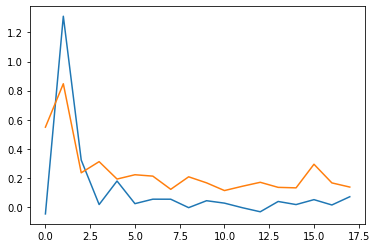

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss', 'acc', 'val_acc'], loc='upper left')
plt.show()

## 모델 정확성 검증

In [26]:
from PIL import Image
import os, glob, numpy as np
from keras.models import load_model

import tensorflow as tf

In [35]:
seed = 5
# tf.set_random_seed(seed)
tf.random.set_seed(seed)
np.random.seed(seed)

caltech_dir = 'img_test'


image_w = 64
image_h = 64

pixels = image_h * image_w * 3

X = []
filenames = []
files = glob.glob(caltech_dir+"/*.*")
for i, f in enumerate(files):
    img = Image.open(f)
    img = img.convert("RGB")
    img = img.resize((image_w, image_h))
    data = np.asarray(img)

    filenames.append(f)
    X.append(data)


X = np.array(X)
X = X.astype(float) / 255
model = load_model('model/food_classify.model')

prediction = model.predict(X)
np.set_printoptions(formatter={'float': lambda x: "{0:0.3f}".format(x)})
cnt = 0
for i in prediction:
    if i >= 0.5: print("해당 " + filenames[cnt].split("/")[1] + "  이미지는 콩자반으로 추정됩니다.")
    else : print("해당 " + filenames[cnt].split("/")[1] + "  이미지는 다른 음식으로 추정됩니다.")
    cnt += 1

해당 Img_027_0083.jpg  이미지는 콩자반으로 추정됩니다.
해당 Img_027_0092.jpg  이미지는 콩자반으로 추정됩니다.
해당 Img_028_0085.jpg  이미지는 콩자반으로 추정됩니다.
해당 Img_027_0089.jpg  이미지는 콩자반으로 추정됩니다.
해당 Img_025_0000.jpg  이미지는 콩자반으로 추정됩니다.
해당 Img_028_0076.jpg  이미지는 콩자반으로 추정됩니다.
해당 Img_025_0011.jpg  이미지는 콩자반으로 추정됩니다.
해당 Img_028_0081.jpg  이미지는 콩자반으로 추정됩니다.
해당 Img_025_0017.png  이미지는 콩자반으로 추정됩니다.
